In [157]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily
import sklearn.cluster
import numpy as np

def make_geo(df_accidents: pd.DataFrame, df_locations: pd.DataFrame) -> geopandas.GeoDataFrame:

    # Sort out only accidents in South Moravian Region
    df_accidents = df_accidents[df_accidents['p4a'] == 6]

    # Merge the two dataframes based on accident ID
    newDf = pd.merge(df_accidents, df_locations, on='p1')

    # Filter out rows with missing coordinates
    newDf = newDf[newDf['d'].notna() & newDf['e'].notna()]

    # Copy the dataframe to avoid SettingWithCopyWarning
    filteredDf = newDf.copy()

    # Swap columns if d is smaller than e (x < y)
    filteredDf[['d', 'e']] = filteredDf[['d', 'e']].where(filteredDf['d'] >= filteredDf['e'], filteredDf[['e', 'd']].values)

    # Create a GeoDataFrame from points in previous dataframe using Krovak projection
    geoDf = geopandas.GeoDataFrame(filteredDf, geometry=geopandas.points_from_xy(filteredDf.d, filteredDf.e), crs='EPSG:5514')

    # print(geoDf.geometry)

    # geoDf = geoDf.to_crs("EPSG:4326")

    # world = geopandas.read_file('ne_110m_admin_0_countries.shp')

    # czechia = world[world['ADMIN'] == 'Czechia']

    # # Plot Czechia map
    # ax = czechia.plot(color='lightgrey', edgecolor='black', figsize=(10, 8))

    # # Ensure CRS matches
    # geoDf = geoDf.to_crs("EPSG:4326")

    # # Plot the points on the map
    # geoDf.plot(ax=ax, color='red', markersize=3)

    # # Add titles and labels
    # plt.title("Points on Czechia Map")
    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")

    # # Show the map
    # plt.savefig('map.png')

    return geoDf

In [202]:
def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None,
             show_figure: bool = False):
    
    # Copy original dataframe to avoid SettingWithCopyWarning
    dfAlcoholOnly = gdf.copy()

    # Filter out only accidents where alcohol was involved
    dfAlcoholOnly = dfAlcoholOnly[dfAlcoholOnly["p11"] >= 4]

    # Create new column with a month of the accident
    dfAlcoholOnly["month"] = pd.to_datetime(dfAlcoholOnly["p2a"], format="%d.%m.%Y").dt.month

    # Reproject the data to GPS coordinates
    dfAlcoholOnly = dfAlcoholOnly.to_crs(epsg=4326)

    fig, axes = plt.subplots(1, 2, figsize=(16, 16))
    dfAlcoholOnly[dfAlcoholOnly["month"] == 1].plot(ax=axes[0], color='red', markersize=3, label="Leden")
    dfAlcoholOnly[dfAlcoholOnly["month"] == 7].plot(ax=axes[1], color='red', markersize=3, label="Červenec")

    for i, ax in enumerate(axes):
        ax.set_title(f'JHM kraj pod vlivem alkoholu - ({"Leden" if i == 0 else "Červenec"})')
        ax.set_xlabel("Nadmořská šířka")
        ax.set_ylabel("Nadmořská výška")
        # ax.set_aspect('equal')
        contextily.add_basemap(ax, crs=dfAlcoholOnly.crs.to_string(), alpha=0.9)

    fig.tight_layout()

    if fig_location:
        plt.savefig(fig_location, bbox_inches='tight')

    # If True, show the figure
    if show_figure:
        plt.show()


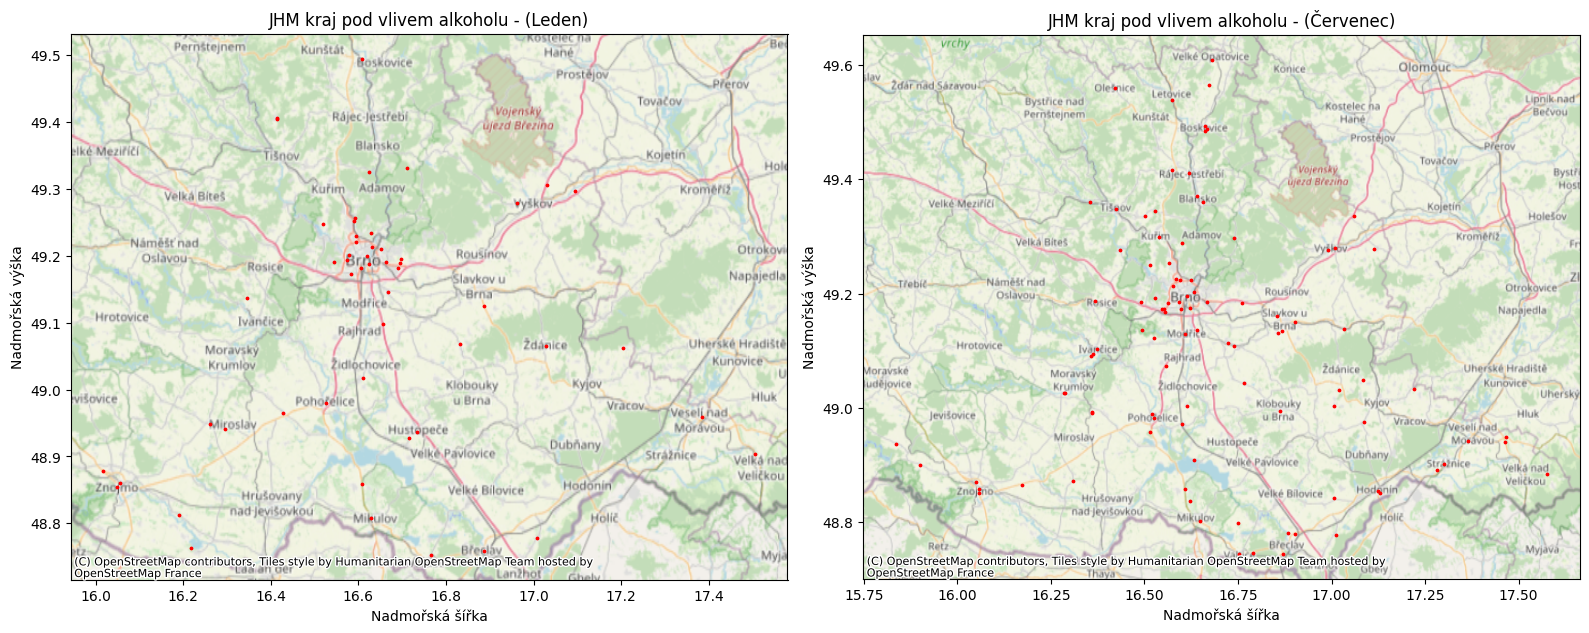

In [203]:
df_accidents = pd.read_pickle("accidents.pkl.gz")
df_locations = pd.read_pickle("locations.pkl.gz")
gdf = make_geo(df_accidents, df_locations)
plot_geo(gdf, "geo1.png", True)